In [35]:
import aiml
import pandas as pd

k = aiml.Kernel()
k.learn("./aiml/novagraphs_abc.xml")

#load questions from file
dataset = pd.read_csv("./validation_data.csv")

dataset[['Global Subject', 'Question Intent']] = dataset[['Global Subject', 'Question Intent']].apply(
    lambda col: col.str.strip().str.upper()
)

dataset.head()

Loading ./aiml/novagraphs_abc.xml...done (0.01 seconds)


,Question,Global Subject,Question Intent
0,Hello!,START,GREET
1,Hi!,START,GREET
2,Hey!,START,GREET
3,Greetings!,START,GREET
4,Hello again!,START,GREET


In [36]:
# # Let's add the OT questions from SQUAD v2
# splits = {'train': 'squad_v2/train-00000-of-00001.parquet',
#           'validation': 'squad_v2/validation-00000-of-00001.parquet'}
# df_squad_v2 = pd.read_parquet("hf://datasets/rajpurkar/squad_v2/" + splits["train"])
#
# # Double square parenthesis to get a dataframe
# sampled_ot_examples = df_squad_v2.sample(100, random_state=102460)[['question']]
# sampled_ot_examples.rename(columns={'question': 'Question'}, inplace=True)
#
# sampled_ot_examples['Global Subject'] = 'OFF_TOPIC'
# sampled_ot_examples['Question Intent'] = ''
#
# dataset = pd.concat([dataset, sampled_ot_examples], ignore_index=True)
#
# dataset

In [37]:
preds_aiml = pd.DataFrame(columns=["aiml_main_prediction", "aiml_sub_prediction"])

for idx, q in enumerate(dataset['Question']):
    pred: str = k.respond(q).upper().strip()

    split = pred.split(':')
    if len(split) == 2:
        preds_aiml.loc[idx] = [split[0], split[1]]
    else:
        preds_aiml.loc[idx] = [pred, "ND"]

preds_aiml

,aiml_main_prediction,aiml_sub_prediction
0,START,GREET
1,START,GREET
2,OFF_TOPIC,ND
3,OFF_TOPIC,ND
4,START,GREET
...,...,...
433,OFF_TOPIC,ND
434,OFF_TOPIC,ND
435,OFF_TOPIC,ND
436,OFF_TOPIC,ND


In [38]:
from pathlib import Path
from system.runner import load_model, BertModelComponents

models_dir = Path("../artifacts/test_config")

submodels_dict: dict[str, Path | None] = {}
for submodel in models_dir.glob("question_intent_*"):
    sub_name = submodel.name.replace("question_intent_", "")

    if (submodel / "trained_model").exists() and any((submodel / "trained_model").iterdir()):
        submodels_dict[sub_name] = submodel
    else:
        submodels_dict[sub_name] = None
        print(f"Skipping {submodel.name} because it does not have a trained model.")

# load each submodel using `load_model` and create a dictionary of submodels.
# If the path is none, set the submodel to none instead of loading it.
submodels: dict[str, BertModelComponents | None] = {}
for name, path in submodels_dict.items():
    submodels[name] = None if path is None else load_model(f"question_intent_{name}", path.parent)

# Main Model loading
model = load_model("global_subject_classifier", Path("../artifacts/test_config"))

preds_bert = pd.DataFrame(columns=["bert_main_prediction", "bert_sub_prediction"])

for idx, q in enumerate(dataset['Question']):
    q: str

    main_class_prediction = model.classify(q)
    main_class = main_class_prediction.get_label()

    sub_class_prediction = submodels[main_class].classify(q) if submodels.get(main_class) else None
    sub_class = sub_class_prediction.get_label().upper() if sub_class_prediction else "ND"

    preds_bert.loc[idx] = [main_class.upper().strip(), sub_class.upper().strip()]

preds_bert

Skipping question_intent_off_topic because it does not have a trained model.
Skipping question_intent_start because it does not have a trained model.


,bert_main_prediction,bert_sub_prediction
0,START,ND
1,START,ND
2,START,ND
3,START,ND
4,START,ND
...,...,...
433,OFF_TOPIC,ND
434,OFF_TOPIC,ND
435,OFF_TOPIC,ND
436,OFF_TOPIC,ND


In [39]:
from sklearn.metrics import classification_report

merged_df = pd.concat([
    dataset,
    preds_aiml,
    preds_bert
], axis=1)

import pandas as pd

merged_df["Question Intent"] = merged_df["Question Intent"].astype(str).fillna("Unknown")


def detect_mixed_types(df):
    # Dictionary to store results
    mixed_columns = {}

    # Check each column for mixed types
    for column in df.columns:
        # Get types of all unique values in the column
        unique_types = df[column].map(type).unique()

        # If multiple types are found, note the column and its types
        if len(unique_types) > 1:
            mixed_columns[column] = unique_types

    return mixed_columns


# Example usage
mixed_columns = detect_mixed_types(merged_df)
if mixed_columns:
    for col, types in mixed_columns.items():
        print(f"Column '{col}' has mixed types: {types}")
else:
    print("No columns with mixed types found.")




merged_df

No columns with mixed types found.


,Question,Global Subject,Question Intent,aiml_main_prediction,aiml_sub_prediction,bert_main_prediction,bert_sub_prediction
0,Hello!,START,GREET,START,GREET,START,ND
1,Hi!,START,GREET,START,GREET,START,ND
2,Hey!,START,GREET,OFF_TOPIC,ND,START,ND
3,Greetings!,START,GREET,OFF_TOPIC,ND,START,ND
4,Hello again!,START,GREET,START,GREET,START,ND
...,...,...,...,...,...,...,...
433,What does the 14th Amendment also introduce th...,OFF_TOPIC,ND,OFF_TOPIC,ND,OFF_TOPIC,ND
434,"Statistically, what is a Jehovah's Witnesses l...",OFF_TOPIC,ND,OFF_TOPIC,ND,OFF_TOPIC,ND
435,What concept does not reach back to the Hebrew...,OFF_TOPIC,ND,OFF_TOPIC,ND,OFF_TOPIC,ND
436,Were there any laws against marriage between w...,OFF_TOPIC,ND,OFF_TOPIC,ND,OFF_TOPIC,ND


In [40]:

# Main class evaluation
print("AIML Main Class Performance:")
print(classification_report(merged_df['Global Subject'], merged_df['aiml_main_prediction']))

print("BERT Main Class Performance:")
print(classification_report(merged_df['Global Subject'], merged_df['bert_main_prediction']))

# Sub class evaluation
print("AIML Sub Class Performance:")
print(classification_report(merged_df['Question Intent'], merged_df['aiml_sub_prediction']))

print("BERT Sub Class Performance:")
print(classification_report(merged_df['Question Intent'], merged_df['bert_sub_prediction']))

AIML Main Class Performance:
                      precision    recall  f1-score   support

                           0.00      0.00      0.00         0
           AUTOMATON       0.45      0.13      0.21        75
             GRAMMAR       0.90      0.13      0.23        70
           OFF_TOPIC       0.27      0.82      0.41       100
OFF_TOPIC  OFF_TOPIC       0.00      0.00      0.00         0
               START       1.00      0.50      0.67        10
               STATE       0.17      0.19      0.18        43
              THEORY       0.00      0.00      0.00        30
          TRANSITION       0.67      0.28      0.40       110

            accuracy                           0.33       438
           macro avg       0.39      0.23      0.23       438
        weighted avg       0.49      0.33      0.30       438

BERT Main Class Performance:
              precision    recall  f1-score   support

   AUTOMATON       0.96      0.89      0.92        75
     GRAMMAR       0.80 

/home/stefa/IdeaProjects/tesi_tln/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stefa/IdeaProjects/tesi_tln/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stefa/IdeaProjects/tesi_tln/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capit

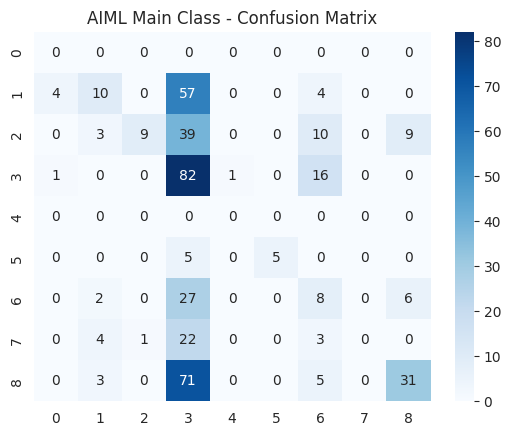

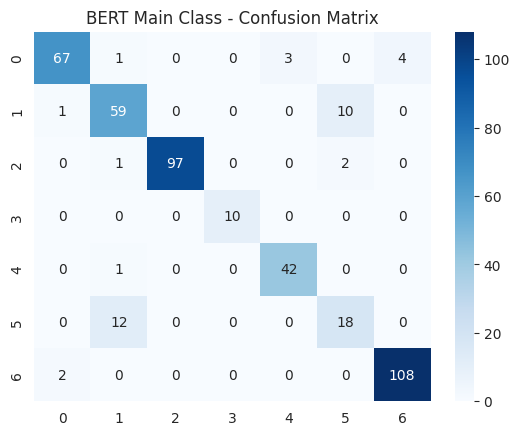

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Main class confusion matrices
conf_matrix = confusion_matrix(merged_df['Global Subject'], merged_df['aiml_main_prediction'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("AIML Main Class - Confusion Matrix")
plt.show()

conf_matrix = confusion_matrix(merged_df['Global Subject'], merged_df['bert_main_prediction'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("BERT Main Class - Confusion Matrix")
plt.show()

In [42]:
# Examples where main classes are correct
correct_main_aiml = merged_df.loc[merged_df['Global Subject'] == merged_df['aiml_main_prediction']]
correct_main_bert = merged_df.loc[merged_df['Global Subject'] == merged_df['bert_main_prediction']]

# Sub class accuracy conditioned on correct main class prediction
conditional_accuracy_aiml = (correct_main_aiml['Question Intent'] == correct_main_aiml['aiml_sub_prediction']).mean()
conditional_accuracy_bert = (correct_main_bert['Question Intent'] == correct_main_bert['bert_sub_prediction']).mean()

print(f"AIML Conditional Sub Class Accuracy: {conditional_accuracy_aiml:.2f}")
print(f"BERT Conditional Sub Class Accuracy: {conditional_accuracy_bert:.2f}")

AIML Conditional Sub Class Accuracy: 0.77
BERT Conditional Sub Class Accuracy: 0.81
